In [3]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import math

%matplotlib inline

46


Text(0.5, 1.0, 'Range of Latent Heat Profiles in Events')

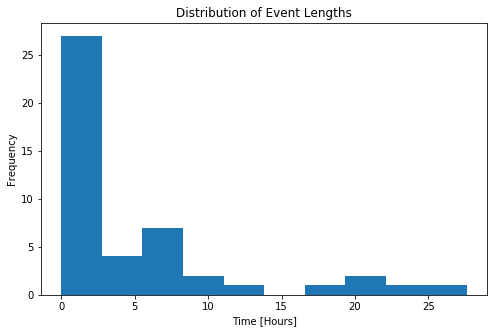

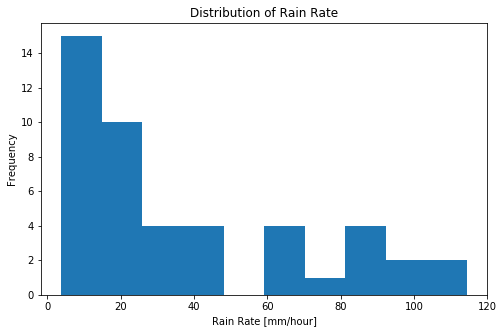

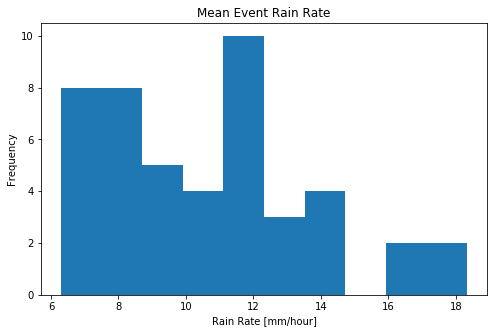

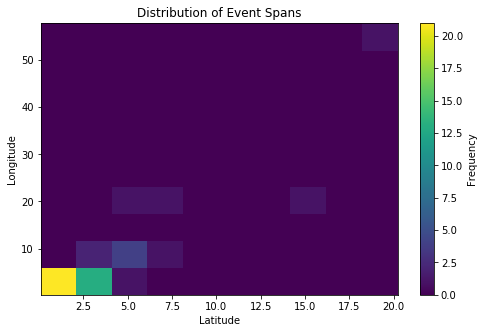

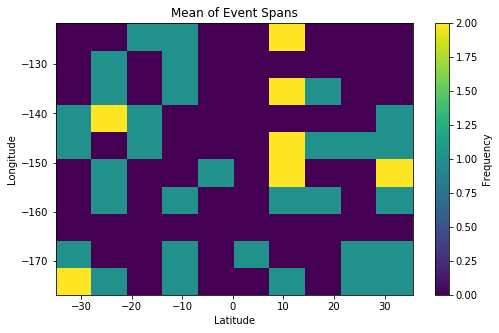

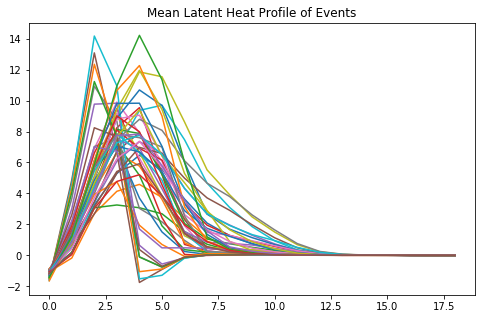

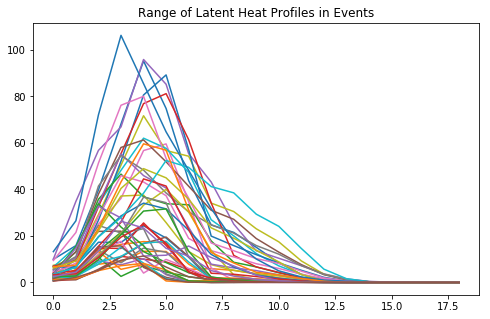

In [96]:
file = xr.open_dataset('SortedData.nc4')
Data = file.Data.data #[delta_time, lat, lon, surface_rain, latent heat profile]
labels = file.Labels.data
Time = file.time.data

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
cluster_spans = np.zeros((len(Data[0,:]),n_clusters_))
cluster_means = np.zeros((len(Data[0,:]),n_clusters_))
for i in range(n_clusters_):
    cluster = Data[labels==i,:]
    cluster_spans[:,i] = np.amax(cluster,axis=0)-np.amin(cluster,axis=0)
    cluster_means[:,i] = np.nanmean(cluster,axis=0)

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[0,:])
plt.title('Distribution of Event Lengths')
plt.xlabel('Time [Hours]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[3,:])
plt.title('Distribution of Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_means[3,:])
plt.title('Mean Event Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')


fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_spans[1,:],cluster_spans[2,:])
plt.title('Distribution of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_means[1,:],cluster_means[2,:])
plt.title('Mean of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_means[4:,:]);
plt.title('Mean Latent Heat Profile of Events')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_spans[4:,:]);
plt.title('Range of Latent Heat Profiles in Events')



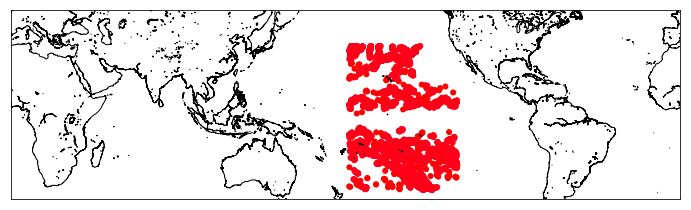

In [97]:
bbox = [-40,50,0,360]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines
m.drawcoastlines()

GridPoints, index = np.unique(Data[:,1:3],axis=0,return_index=True)
GridPoints = Data[index,1:3]

events_count = np.zeros((len(GridPoints)))

for i in range(len(GridPoints)):
    indices = np.array(np.argwhere(np.all((Data[:,1:3]==GridPoints[i,:]),axis=1)))
    clusters = [labels[int(j)] for j in indices]
    cluster = np.unique(clusters)
    num = cluster[cluster>-1]
    events_count[i]= len(num)

labels_min = 0
labels_max = np.max(events_count)

m.scatter(GridPoints[:,1],GridPoints[:,0], latlon=True, c=events_count, s=25,cmap='hsv')



In [99]:
print(np.max(events_count))

1.0
